### UPLIFT Modeling

In [1]:
import pandas as pd
pd.options.display.max_rows=100
pd.options.display.max_columns=100
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve,roc_auc_score,roc_curve
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier
# from sklift.models import ClassTransformation
from IPython.display import Image
# from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
import warnings
from sklearn.metrics import classification_report, confusion_matrix
import itertools
warnings.filterwarnings('ignore')

/home/andreyl/Soft/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


##### Чтение файла

In [2]:
df = pd.read_csv('data.csv')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


##### Генерация признаков

In [4]:
df.loc[df['offer']!='No Offer','offer']=1
df.loc[df['offer']=='No Offer','offer']=0
df.rename(columns={'offer':'treatment','conversion':'target'},inplace=True)
df['treatment'] = df['treatment'].astype('bool')

In [5]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,True,0
1,6,329.08,1,1,Rural,1,Web,False,0
2,7,180.65,0,1,Surburban,1,Web,True,0
3,9,675.83,1,0,Rural,1,Web,True,0
4,2,45.34,1,0,Urban,0,Web,True,0


In [6]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,target
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


In [7]:
df['history_group'] = pd.cut(df['history'],[0,df['history'].quantile(0.25),df['history'].quantile(0.75),df['history'].quantile(1)],labels = ['history_1','history_2','history_3'])
df['recency_group'] = pd.cut(df['recency'],[0,df['recency'].quantile(0.25),df['recency'].quantile(0.75),df['recency'].quantile(1)],labels = ['recency_1','recency_2','recency_3'])
df = pd.get_dummies(df,columns=['history_group','zip_code','channel','recency_group'], prefix=['group','code','channel','recency'],drop_first=True)
df.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,target,group_history_2,group_history_3,code_Surburban,code_Urban,channel_Phone,channel_Web,recency_recency_2,recency_recency_3
0,10,142.44,1,0,0,True,0,1,0,1,0,1,0,0,1
1,6,329.08,1,1,1,False,0,0,1,0,0,0,1,1,0
2,7,180.65,0,1,1,True,0,1,0,1,0,0,1,1,0
3,9,675.83,1,0,1,True,0,0,1,0,0,0,1,1,0
4,2,45.34,1,0,0,True,0,0,0,0,1,0,1,0,0


#### одна модель

##### 1 (GradientBoostingClassifier, LogisticRegression)

##### Сначала попробуем использовать "обычные" методы для uplift-моделирования

LogisticRegression 0.07644457904300425 - 0.10708661417322834
precision 0.0 recall 0.0 rocauc_score 0.6431586366734993
GradientBoostingClassifier 0.09563294972743794 - 0.10908540278619017


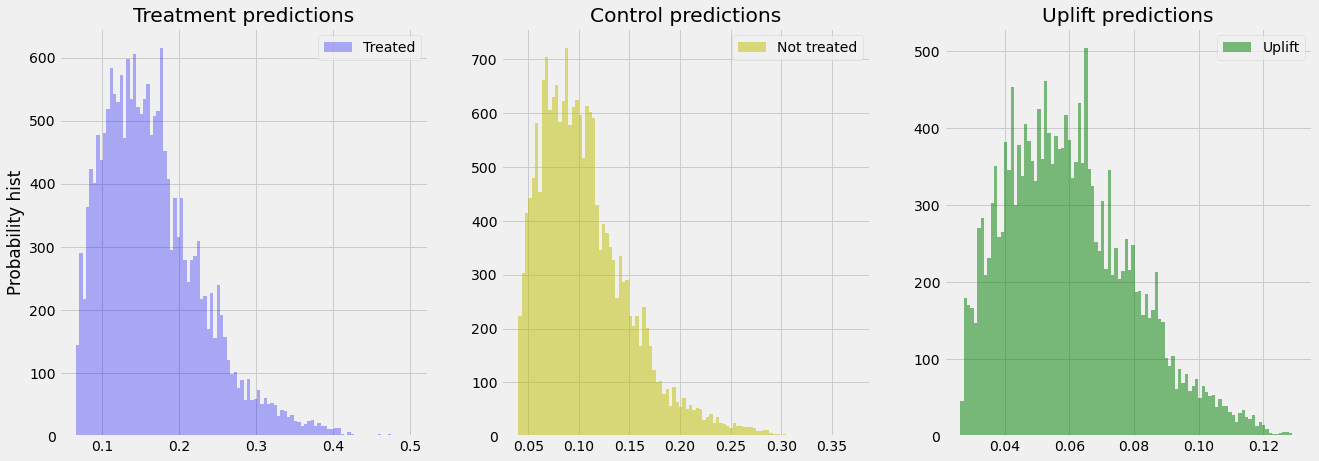

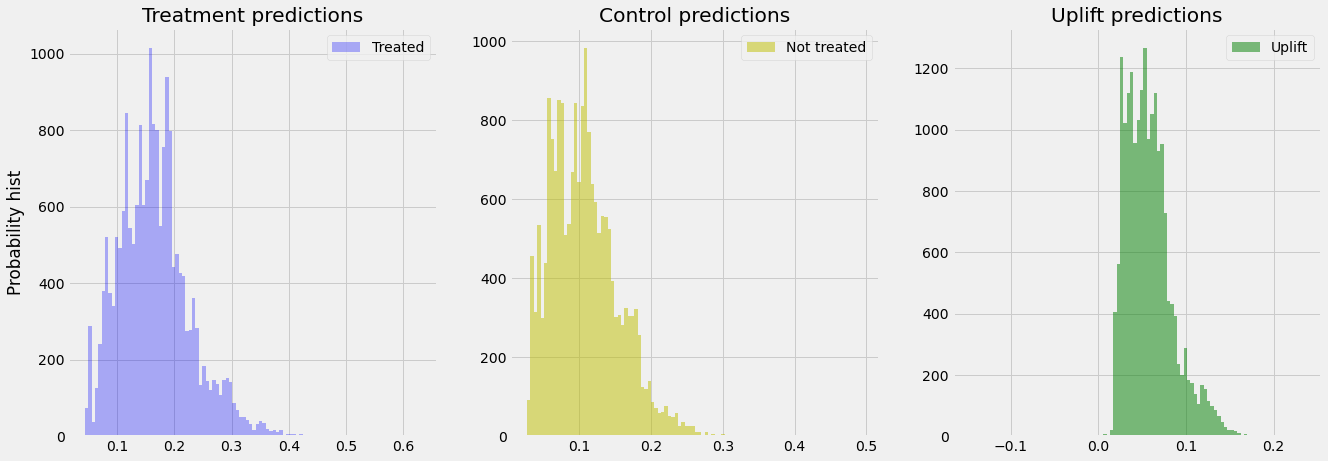

In [13]:
from sklearn.preprocessing import StandardScaler
features = df.columns.drop('target')
scaler = StandardScaler()
x_train,x_test,y_train,y_test = train_test_split(df[features],df['target'],test_size = 0.3,random_state = 1)
# x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train[features.drop('treatment')]),columns=features.drop('treatment'))
# x_test_scaled = pd.DataFrame(scaler.transform(x_test[features.drop('treatment')]),columns=features.drop('treatment'))
# x_train_scaled['treatment'] = x_train.treatment
# x_train_scaled['treatment'] = x_train_scaled['treatment'].astype('bool')
# x_test_scaled['treatment'] = x_test.treatment
# x_test_scaled['treatment'] = x_test_scaled['treatment'].astype('bool')

models_results = {}

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
LR = LogisticRegression(max_iter=10000)
GBS = GradientBoostingClassifier()
LR.fit(x_train,y_train)
GBS.fit(x_train,y_train)
x_test_1 = x_test.copy()
x_test_2 = x_test.copy()
x_test_1['treatment'] = 0
x_test_2['treatment'] = 1
y_hat_1 = LR.predict_proba(x_test_1)
y_hat_2 = LR.predict_proba(x_test_2)
uplift = y_hat_2[:,-1]-y_hat_1[:,-1]
plot_uplift_preds(y_hat_2[:,-1],y_hat_1[:,-1])
sm_score_scoring = {}
sm_score_02 = uplift_at_k(y_true=y_test, uplift=uplift, treatment=x_test['treatment'], strategy='by_group', k=0.2)
sm_score_01 = uplift_at_k(y_true=y_test, uplift=uplift, treatment=x_test['treatment'], strategy='by_group', k=0.1)
sm_score_scoring[0.2]=sm_score_02
sm_score_scoring[0.1]=sm_score_01
print('LogisticRegression',sm_score_02,'-',sm_score_01)
models_results['LR, 1 model'] = sm_score_scoring
y_hat_1 = GBS.predict_proba(x_test_1)
y_hat_2 = GBS.predict_proba(x_test_2)
y_hat = GBS.predict_proba(x_test)[:,1]
uplift = y_hat_2[:,-1]-y_hat_1[:,-1]
plot_uplift_preds(y_hat_2[:,-1],y_hat_1[:,-1])
sm_score_scoring = {}
sm_score_02 = uplift_at_k(y_true=y_test, uplift=uplift, treatment=x_test['treatment'], strategy='by_group', k=0.2)
sm_score_01 = uplift_at_k(y_true=y_test, uplift=uplift, treatment=x_test['treatment'], strategy='by_group', k=0.1)
sm_score_scoring[0.2]=sm_score_02
sm_score_scoring[0.1]=sm_score_01
precision, recall, thresholds = precision_recall_curve(y_test,y_hat)
fscore = precision*recall/(precision+recall)
ix = np.argmax(fscore)
threshold = thresholds[ix]
rocauc_score = roc_auc_score(y_test,y_hat)
print('precision',precision[ix], 'recall',recall[ix], 'rocauc_score',rocauc_score)
print('GradientBoostingClassifier',sm_score_02,'-',sm_score_01)
models_results['GBC, 1 model'] = sm_score_scoring

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     16383
           1       0.00      0.00      0.00      2817

    accuracy                           0.85     19200
   macro avg       0.43      0.50      0.46     19200
weighted avg       0.73      0.85      0.79     19200

Confusion matrix, without normalization
[[16378     5]
 [ 2817     0]]


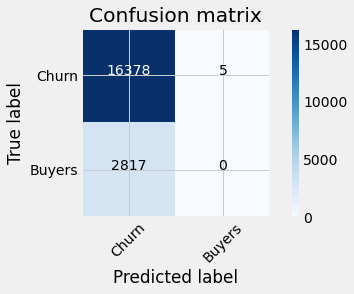

In [14]:
# function to print the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
##########################################################################
# Confusion Matrix is printed
##########################################################################
  
##########################################################################
# Parameters for Confusion Matrix
# y_test = реальные данные в тестовой выборке
# y_test_hat = предсказанные значения для модели с k=количество групп
##########################################################################

cnf_matrix = confusion_matrix(y_test, y_hat>threshold, labels=[0,1])
np.set_printoptions(precision=4)

print (classification_report(y_test, y_hat>threshold))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Churn','Buyers'],normalize= False,  title='Confusion matrix')

##### ROC_AUC 0.64 не очень-то и большой... попробуем использовать uplift для уточнения веса признаков;
##### uplift отображает склонность совершить действие, то, видимо, является неким интегральным показателем всех признаков, которыми обладает пользователь; и почему бы не использовать его как некий вес для всех признаков. Сам факт того, что человек на 5% более склонен что-то сделать еще не дает нам возможность улучшить прогноз, ведь м.б. для совершения им нужного для нас действия нужно сдвинуть эту склонность на 10% или лаже на 20... Но если выявлено, что, например, по каким-то причинам красная одежда и белая машина (условно) в сочетании с нашим воздействием на клиента на 5% делают его более лояльным, значит, красная одежда и белая машина имеют больший вес, чем одежда и машина пользователей, которые после контакта с нами не становятся более лояльными или становятся, но только на 1%.

LogisticRegression 0.22689221256938152 - 0.17786469269729155
precision 0.224217242914379 recall 0.9993386243386243 rocauc_score 0.8670351308333275
GradientBoostingClassifier 0.19593551879942722 - 0.1778242148563796


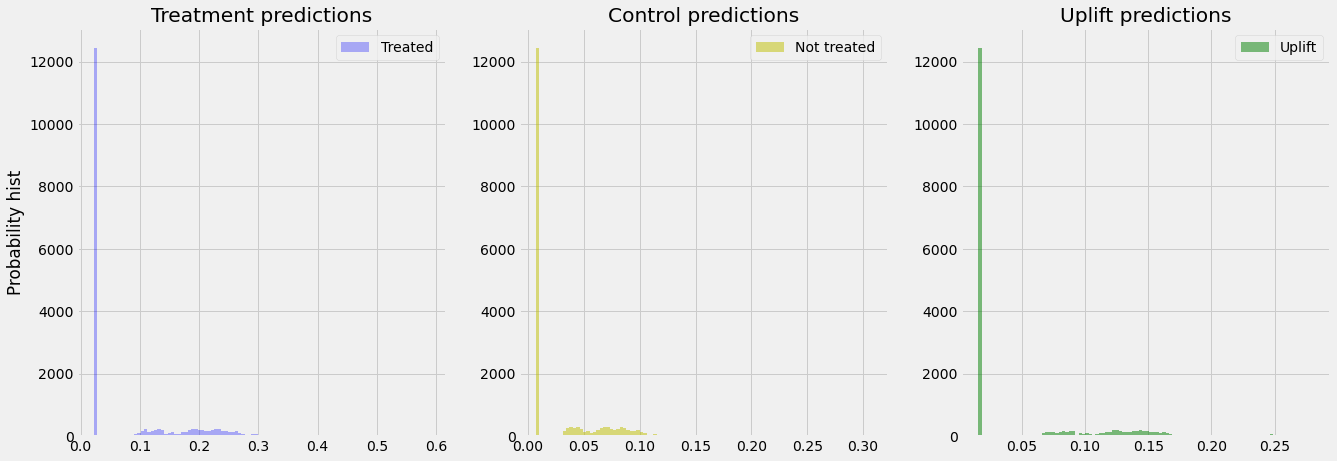

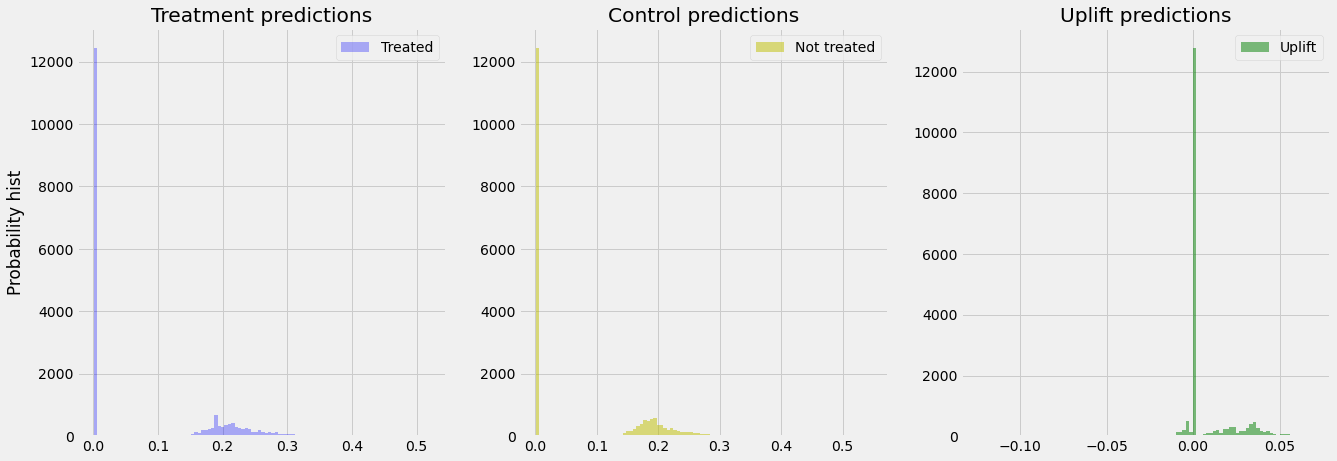

In [15]:
y_pred = GBS.predict_proba(x_test)[:,1]>0.165 # это uplift, расчитанный для тестовой выборки; 0.165 подобран вручную: просто примерная граница uplift по графику; наверное, есть и еще более лучшее разделение
y_pred_train = GBS.predict_proba(x_train)[:,1]>0.165 # это uplift, расчитанный для тренировочной выборки
uplift = list(y_pred_train)+list(y_pred) # это весь uplift, соединенный в один список: тренировочный + тестовый
# формируем весь датафрейм еще раз, чтобы сохранить соответствие данных, uplift'а и целевых показателей
x_train['target']=y_train
x_test['target']=y_test

df_new = x_train.append(x_test)
for i in df_new:
    df_new[i] = df_new[i]*uplift
x_train,x_test,y_train,y_test = train_test_split(df_new[features],df_new['target'],test_size = 0.3,random_state = 1)


models_results = {}

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
LR = LogisticRegression(max_iter=10000)
GBS = GradientBoostingClassifier()
LR.fit(x_train,y_train)
GBS.fit(x_train,y_train)
x_test_1 = x_test.copy()
x_test_2 = x_test.copy()
x_test_1['treatment'] = 0
x_test_2['treatment'] = 1
y_hat_1 = LR.predict_proba(x_test_1)
y_hat_2 = LR.predict_proba(x_test_2)
uplift = y_hat_2[:,-1]-y_hat_1[:,-1]
plot_uplift_preds(y_hat_2[:,-1],y_hat_1[:,-1])
sm_score_scoring = {}
sm_score_02 = uplift_at_k(y_true=y_test, uplift=uplift, treatment=x_test['treatment'], strategy='by_group', k=0.2)
sm_score_01 = uplift_at_k(y_true=y_test, uplift=uplift, treatment=x_test['treatment'], strategy='by_group', k=0.1)
sm_score_scoring[0.2]=sm_score_02
sm_score_scoring[0.1]=sm_score_01
print('LogisticRegression',sm_score_02,'-',sm_score_01)
models_results['LR, 1 model'] = sm_score_scoring
y_hat_1 = GBS.predict_proba(x_test_1)
y_hat_2 = GBS.predict_proba(x_test_2)
y_hat = GBS.predict_proba(x_test)[:,1]
uplift = y_hat_2[:,1]-y_hat_1[:,1]
plot_uplift_preds(y_hat_2[:,-1],y_hat_1[:,-1])
sm_score_scoring = {}
sm_score_02 = uplift_at_k(y_true=y_test, uplift=uplift, treatment=x_test['treatment'], strategy='by_group', k=0.2)
sm_score_01 = uplift_at_k(y_true=y_test, uplift=uplift, treatment=x_test['treatment'], strategy='by_group', k=0.1)
sm_score_scoring[0.2]=sm_score_02
sm_score_scoring[0.1]=sm_score_01
precision, recall, thresholds = precision_recall_curve(y_test,y_hat)
fscore = precision*recall/(precision+recall)
ix = np.argmax(fscore)
threshold = thresholds[ix]
rocauc_score = roc_auc_score(y_test,y_hat)
print('precision',precision[ix], 'recall',recall[ix], 'rocauc_score',rocauc_score)
print('GradientBoostingClassifier',sm_score_02,'-',sm_score_01)
models_results['GBC, 1 model'] = sm_score_scoring

In [16]:
threshold

0.1358836410859586

#####  Как видно, достигнут уровень ROC_AUC, превышающий изначальный более, чем на 20%.
##### ...и recall почти 100%, правда, при precision всего 22%; м.б. это не много, но лучше, чем результат, полученный в первой матрице ошибок.

              precision    recall  f1-score   support

           0       1.00      0.70      0.83     17688
           1       0.22      1.00      0.37      1512

    accuracy                           0.73     19200
   macro avg       0.61      0.85      0.60     19200
weighted avg       0.94      0.73      0.79     19200

Confusion matrix, without normalization
[[12461  5227]
 [    2  1510]]


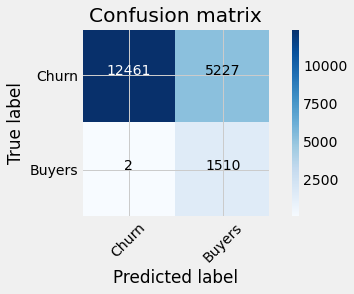

In [19]:
cnf_matrix = confusion_matrix(y_test, y_hat>threshold, labels=[0,1])
np.set_printoptions(precision=4)

print (classification_report(y_test, y_hat>threshold))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Churn','Buyers'],normalize= False,  title='Confusion matrix')

##### 2 (SoloLearn)

SoloLearn 0.06959963149929027 - 0.10206608042346112


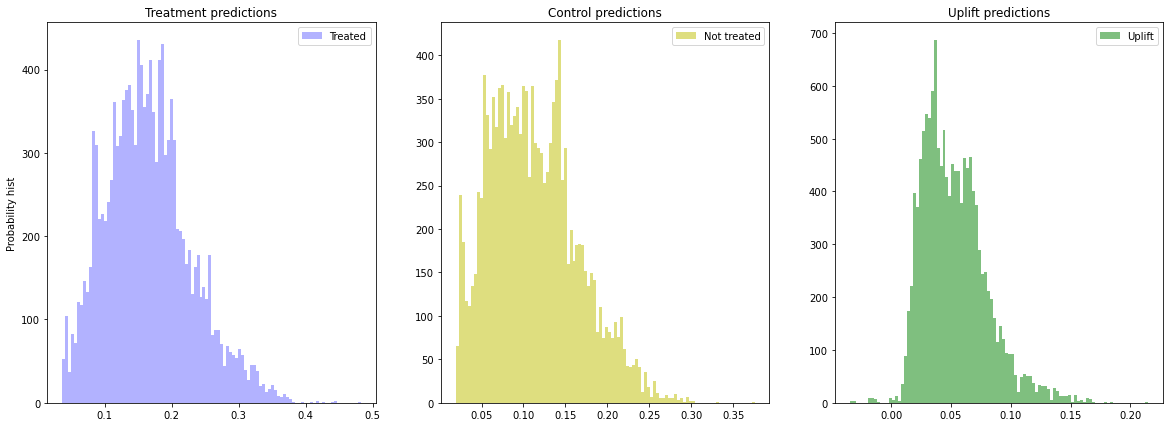

In [9]:
indices_learn, indices_valid = train_test_split(x_train.index, test_size=0.3, random_state=0)
X_train = x_train.loc[indices_learn, features]
Y_train = y_train[indices_learn]
treat_train = x_train.loc[indices_learn, 'treatment']

X_val = x_train.loc[indices_valid, features]
Y_val = y_train[indices_valid]
treat_val =  x_train.loc[indices_valid, 'treatment']

sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=20, silent=True))
sm = sm.fit(X_train, Y_train, treat_train)

uplift_sm = sm.predict(X_val)
sm_score_scoring = {}
sm_score_02= uplift_at_k(y_true=Y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)
sm_score_01 = uplift_at_k(y_true=Y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_scoring[0.2]=sm_score_02
sm_score_scoring[0.1]=sm_score_01
print('SoloLearn',sm_score_02,'-',sm_score_01)
models_results['SoloLearn, 1 model'] = sm_score_scoring
# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);


In [10]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,recency,14.626339
1,is_referral,14.153523
2,treatment,12.828576
3,history,11.976021
4,used_bogo,10.255876
5,used_discount,8.861244
6,channel_Web,7.242245
7,code_Urban,5.083465
8,code_Surburban,4.484903
9,channel_Phone,4.329092


In [11]:
pd.DataFrame(models_results)

,"LR, 1 model","GBC, 1 model","SoloLearn, 1 model"
0.2,0.077214,0.095633,0.069600
0.1,0.102399,0.109085,0.102066


##### Трансформация классов

In [12]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct.fit(X_train, Y_train, treat_train, estimator_fit_params={'plot': True})

uplift_ct = ct.predict(X_val)

ct_score_02 = uplift_at_k(y_true=Y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)
ct_score_01 = uplift_at_k(y_true=Y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_scoring = {}
sm_score_scoring[0.2]=ct_score_02
sm_score_scoring[0.1]=ct_score_01
models_results['ClassTransformation, 1 model']=sm_score_scoring
pd.DataFrame(models_results)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

,"LR, 1 model","GBC, 1 model","SoloLearn, 1 model","ClassTransformation, 1 model"
0.2,0.077214,0.095633,0.069600,0.206112
0.1,0.102399,0.109085,0.102066,0.244856


#### две модели

##### LogisticRegression

In [14]:
x_train,x_test,y_train,y_test = train_test_split(df[features],df['target'],random_state = 42)
x_train_t=x_train[x_train['treatment']==1]
x_train_t_indecies = x_train[x_train['treatment']==1].index
y_train_t = y_train[x_train_t_indecies]
x_train_c=x_train[x_train['treatment']==0]
x_train_c_indecies = x_train[x_train['treatment']==0].index
y_train_c = y_train[x_train_c_indecies]


LR_t = LogisticRegression(max_iter=10000,solver='liblinear',penalty='l1')
LR_c = LogisticRegression(max_iter=10000,solver='liblinear',penalty='l1')
LR_t.fit(x_train_t,y_train_t)
LR_c.fit(x_train_c,y_train_c)

y_hat_t = LR_t.predict_proba(x_test)[:,-1]
y_hat_c = LR_c.predict_proba(x_test)[:,-1]
uplift = y_hat_t-y_hat_c
score02 = uplift_at_k(y_test,uplift,x_test['treatment'], strategy='by_group', k=0.2)
score01 = uplift_at_k(y_test,uplift,x_test['treatment'], strategy='by_group', k=0.1)
sm_score_scoring = {}
sm_score_scoring[0.2]=score02
sm_score_scoring[0.1]=score01
models_results['LR, 2 models']=sm_score_scoring
print(score02,score01)

0.10592836793194121 0.1277756306654487


##### TwoModels

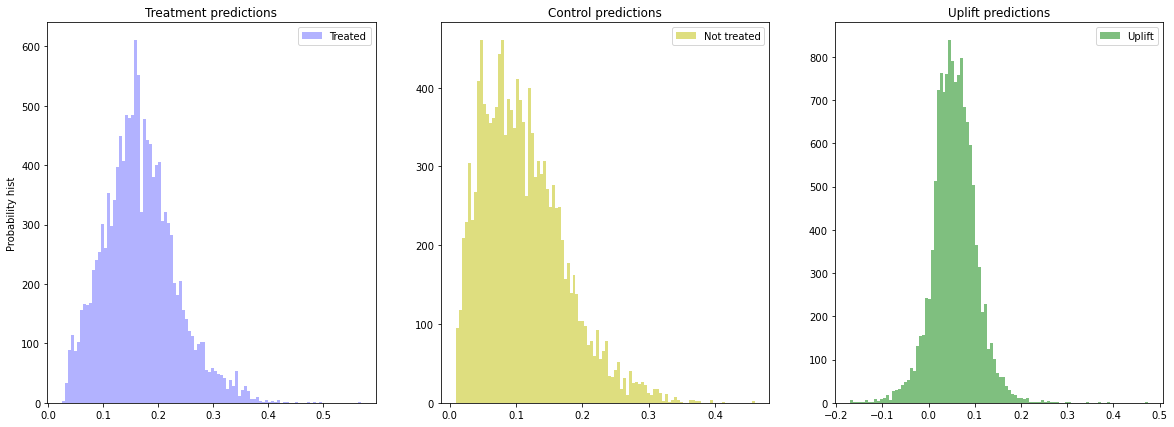

In [15]:
from sklift.models import TwoModels
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, Y_train, treat_train
)

uplift_tm = tm.predict(X_val)

tm_score02 = uplift_at_k(y_true=Y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)
tm_score01 = uplift_at_k(y_true=Y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)

sm_score_scoring = {}
sm_score_scoring[0.2]=tm_score02
sm_score_scoring[0.1]=tm_score01
models_results['TwoModels, 2 models']=sm_score_scoring
plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [17]:
pd.DataFrame(models_results).T

,0.2,0.1
"LR, 1 model",0.077214,0.102399
"GBC, 1 model",0.095633,0.109085
"SoloLearn, 1 model",0.069600,0.102066
"ClassTransformation, 1 model",0.206112,0.244856
"LR, 2 models",0.105928,0.127776
"TwoModels, 2 models",0.089219,0.098480
